In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm

import datetime
import pickle
import importlib
import json
import time
import glob

In [2]:
selected_band=pd.read_pickle('data//selected_band.pkl')

In [3]:
selected_band

,Line Name,Wavelength Range,Temperature,Accurate Wavelength,Initial Guess,Wavelength Index
0,Ni XI 148,"[14.75, 14.93]",6.20,148.377,"[0.00011, 14.84, 0.0424]","[588, 589, 590, 591, 592, 593, 594, 595, 596]"
1,O VI 150,"[14.93, 15.09]",5.50,150.089,"[4.4e-05, 15.01, 0.0424]","[597, 598, 599, 600, 601, 602, 603, 604]"
2,Ni XII 152,"[15.13, 15.35]",6.30,152.151,"[6.5e-05, 15.22, 0.0424]","[607, 608, 609, 610, 611, 612, 613, 614, 615, ..."
3,Fe XXIII 154,"[15.35, 15.53]",7.15,154.303,"[4e-05, 15.42, 0.0424]","[618, 619, 620, 621, 622, 623, 624, 625, 626]"
4,Fe IX 171,"[17, 17.21]",6.20,171.073,"[0.0006, 17.11, 0.0424]","[700, 701, 702, 703, 704, 705, 706, 707, 708, ..."
5,Fe IX 174,"[17.37, 17.59]",6.05,174.531,"[0.00069, 17.45, 0.0424]","[719, 720, 721, 722, 723, 724, 725, 726, 727, ..."
6,Fe X 177,"[17.63, 17.83]",6.05,177.240,"[0.00045, 17.72, 0.0424]","[732, 733, 734, 735, 736, 737, 738, 739, 740, ..."
7,Fe XI 180,"[17.95, 18.15]",6.15,180.401,"[0.0006, 18.05, 0.0424]","[748, 749, 750, 751, 752, 753, 754, 755, 756, ..."
8,Fe XI 182,"[18.15, 18.31]",6.15,182.167,"[0.00013, 18.22, 0.0424]","[758, 759, 760, 761, 762, 763, 764, 765]"
9,Fe X 185,"[18.35, 18.59]",6.05,184.537,"[0.0002, 18.45, 0.0424]","[768, 769, 770, 771, 772, 773, 774, 775, 776, ..."


# He304

this part starts from one data per day.
As for the details of how to get the data from every 10s to every 1 day, please refer to the Chapter4_v2 part.

In [7]:
He_304_df=pd.read_pickle('data\daily_df\daily_df_He II 304.pkl')

In [8]:
He_304_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data,median_of_doppler
time,,,,,,,,
2010-04-30,30.374138,0.028910,0.006518,0.000175,0.000076,0.000058,8570,-38111.996615
2010-05-01,30.374133,0.028986,0.006556,0.000199,0.000070,0.000052,8579,-38160.802198
2010-05-02,30.374000,0.029030,0.006503,0.000210,0.000070,0.000048,8579,-39474.399806
2010-05-03,30.373922,0.029038,0.006513,0.000206,0.000102,0.000049,8640,-40242.375199
2010-05-04,30.373876,0.029006,0.006656,0.000195,0.000092,0.000059,8578,-40695.889590
...,...,...,...,...,...,...,...,...
2014-05-21,30.372141,0.031075,0.006630,0.000374,0.000141,0.000055,8581,-57825.837271
2014-05-22,30.372299,0.030988,0.006608,0.000357,0.000127,0.000065,8582,-56259.576031
2014-05-23,30.372543,0.030948,0.006646,0.000359,0.000135,0.000047,8582,-53852.726201


Text(0, 0.5, 'Available Data')

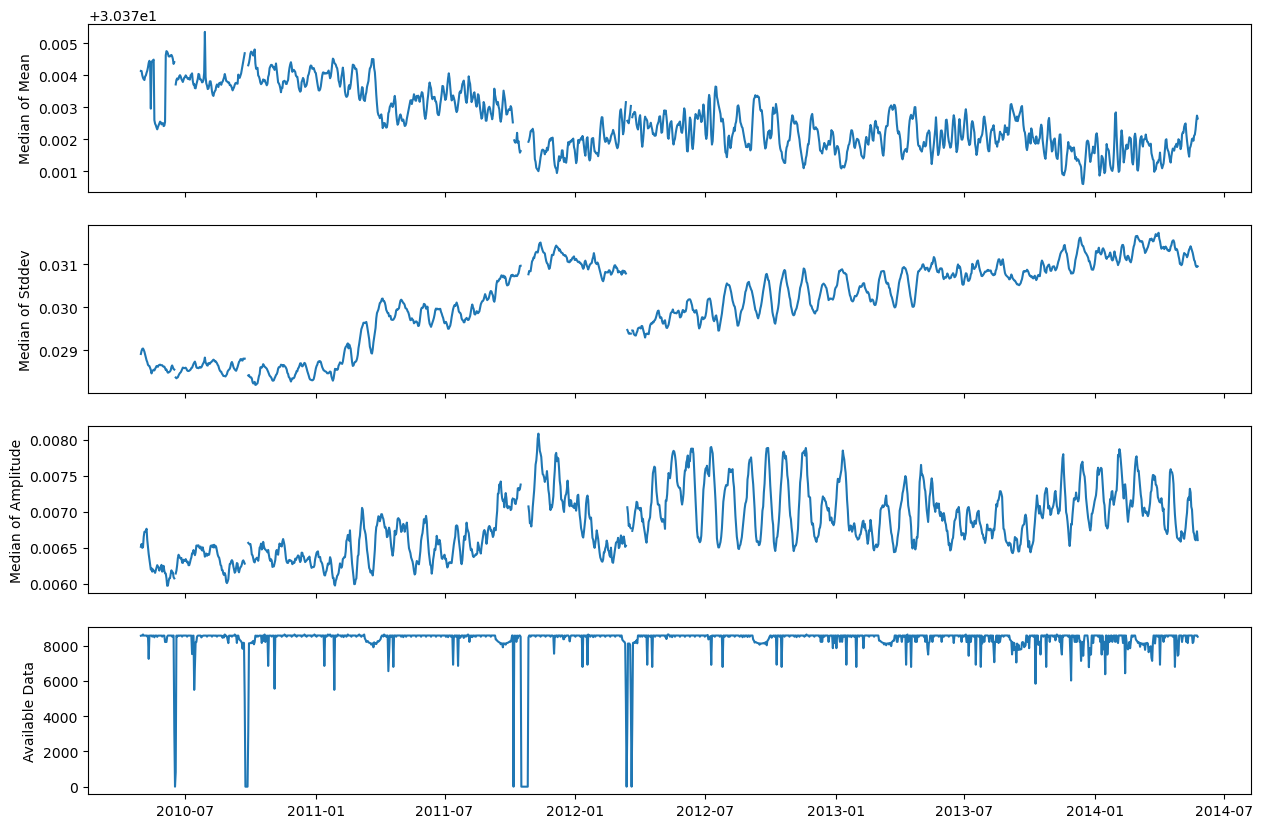

In [14]:
fig,axs=plt.subplots(4,1,figsize=(15,10),sharex=True)
axs[0].plot(He_304_df.index,He_304_df['median_of_mean'])
axs[0].set_ylabel('Median of Mean')

axs[1].plot(He_304_df.index,He_304_df['median_of_stddev'])
axs[1].set_ylabel('Median of Stddev')

axs[2].plot(He_304_df.index,He_304_df['median_of_amplitude'])
axs[2].set_ylabel('Median of Amplitude')

axs[3].plot(He_304_df.index,He_304_df['available_data'])
axs[3].set_ylabel('Available Data')

In [121]:
def plot(eve_df,aia_df):
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=.011)

    valid_day=np.where(eve_df['available_data']>=np.nanmean(eve_df['available_data'])*0.2,1,np.nan)
    x = eve_df.index
    y_median = eve_df['median_of_mean']*valid_day
    y_stddev = eve_df['stddev_of_mean']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    # Plot the mean line
    fig.add_trace(go.Scatter(x=x, y=y_median,
                                 showlegend=False, 
                           line=dict(color='rgb(0,128,255)', )) ,
               row=1, col=1,)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                 fill='tozerox', 
                                 fillcolor='rgba(0,176,246,0.2)',
                                 line=dict(color='rgba(127,255,0,0.2)'),
                                 showlegend=False, 
                                 name='3 Std. Dev.'),
               row=1, col=1)

    fig.update_yaxes(title_text="Mean (nm)",range=[30.3705, 30.3755],row=1, col=1)
    # Show the plot



    # Create a figure for fwhm
    x = eve_df.index
    y_median = eve_df['median_of_stddev']*valid_day*gaussian_sigma_to_fwhm
    y_stddev = eve_df['stddev_of_stddev']*gaussian_sigma_to_fwhm
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    fig.add_trace(go.Scatter(x=x, y=y_median,
                              showlegend=False,
                           line=dict(color='rgb(0,128,255)'),),
                        row=2, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                 fill='tozerox', 
                                 fillcolor='rgba(0,176,246,0.2)',
                                 line=dict(color='rgba(127,255,0,0.2)'),
                                 showlegend=False,
                                 name='3 Std. Dev.'),
                     row=2, col=1)

    fig.update_yaxes(title_text="FWHM (nm)",
                  range=[0.065, 0.076],
                  row=2, col=1)





    # # Create a figure for amplitude
    x = eve_df.index
    y_median = eve_df['median_of_amplitude']*valid_day
    y_stddev = eve_df['stddev_of_amplitude']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])


    fig.add_trace(go.Scatter(x=eve_df.index, y=y_median,
                                          showlegend=False,
                           line=dict(color='rgb(0,128,255)'),),
                           row=3, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                 fill='tozerox', 
                                 fillcolor='rgba(0,176,246,0.2)',
                                 line=dict(color='rgba(127,255,0,0.2)'),
                                 showlegend=False, 
                                 name='3 Std. Dev.'),
                        row=3, col=1)

    fig.update_yaxes(title_text='Amplitude (nm)',range=[0.0059, 0.0082],row=3, col=1)



    # # Create a figure for data available
    x = eve_df.index
    fig.add_trace(go.Scatter(x=x,y=eve_df['available_data'],
                              showlegend=False,
                           line=dict(color='rgb(0,128,255)')),
               row=4, col=1)
    

# Add red lines in cruciform_df.loc[:,'Date'] to all the subplots
    cruciform_df = pd.read_pickle('data/catalog/cruciform_df.pkl')
    for i in range(len(cruciform_df)):
        fig.add_shape(type="line", x0=cruciform_df.loc[i, 'Date'], y0=0, x1=cruciform_df.loc[i, 'Date'], y1=100,
                      line=dict(color="Red", width=1), row=1, col=1)
        fig.add_shape(type="line", x0=cruciform_df.loc[i, 'Date'], y0=0, x1=cruciform_df.loc[i, 'Date'], y1=1,
                      line=dict(color="Red", width=1), row=2, col=1)
        fig.add_shape(type="line", x0=cruciform_df.loc[i, 'Date'], y0=0, x1=cruciform_df.loc[i, 'Date'], y1=1,
                      line=dict(color="Red", width=1), row=3, col=1)
        fig.add_shape(type="line", x0=cruciform_df.loc[i, 'Date'], y0=0, x1=cruciform_df.loc[i, 'Date'], y1=8640,
                      line=dict(color="Red", width=1), row=4, col=1)

    # Add an invisible scatter trace to include the red lines in the legend
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color="Red", width=1),
                             name='Cruciform Scan Days', showlegend=True))

    fig.update_xaxes(range=[eve_df.index[0], eve_df.index[-1]], row=4, col=1)

    # Update the layout
    fig.update_layout(width=1200,height=1500,
                        title_text="EVE: He304 obs: Daily Median, Standard Deviation, Amplitude and Valid Data Number",
                        legend=dict(x=1, y=0.9)) 
    fig.update_yaxes(title_text='available data',row=4, col=1)

    fig.update_xaxes(title_text="Time",row=4, col=1)

    fig.show()

    print([eve_df.index[0],eve_df.index[-1]])

    fig.write_html("..//output//eve_obs//EVE_obs.html")

In [122]:
plot(He_304_df,None)

[Timestamp('2010-04-30 00:00:00'), Timestamp('2014-05-25 00:00:00')]


In [123]:
cruciform_df = pd.read_pickle('data/catalog/cruciform_df.pkl')

### Choose the start and end date of the data
I can do a fit for each part of it, but I would like to one section of time.

In [131]:
start_time=cruciform_df.loc[10,'Date']
end_time=cruciform_df.loc[11,'Date']
print(start_time,end_time)

2012-07-10 00:00:00 2012-10-10 00:00:00
